# Chapter 6 - Linear Model Selection and Regularization

- [Lab 2: Ridge Regression](#6.6.1-Ridge-Regression)
- [Lab 2: The Lasso](#6.6.2-The-Lasso)
- [Lab 3: Principal Components Regression](#6.7.1-Principal-Components-Regression)
- [Lab 3: Partial Least Squares](#6.7.2-Partial-Least-Squares)

In [2]:
!pip install glmnet # install glmnet before import

     |████████████████████████████████| 1.6MB 4.3MB/s 


In [3]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import glmnet as gln

from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('seaborn-white')

# Lab 2

In [5]:
# In R, I exported the dataset from package 'ISLR' to a csv file.
df = pd.read_csv('https://raw.githubusercontent.com/borisgarbuzov/schulich_data_science_1/master/Data/Hitters.csv', index_col=0).dropna()
df.index.name = 'Player'
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 

In [6]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Player,,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [7]:
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
dummies.info()
print(dummies.head())

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   League_A     263 non-null    uint8
 1   League_N     263 non-null    uint8
 2   Division_E   263 non-null    uint8
 3   Division_W   263 non-null    uint8
 4   NewLeague_A  263 non-null    uint8
 5   NewLeague_N  263 non-null    uint8
dtypes: uint8(6)
memory usage: 3.6+ KB
                   League_A  League_N  ...  NewLeague_A  NewLeague_N
Player                                 ...                          
-Alan Ashby               0         1  ...            0            1
-Alvin Davis              1         0  ...            1            0
-Andre Dawson             0         1  ...            0            1
-Andres Galarraga         0         1  ...            0            1
-Alfredo Griffin          1         0  ...            1            0

[5 rows x 6 columns]


In [8]:
y = df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AtBat        263 non-null    float64
 1   Hits         263 non-null    float64
 2   HmRun        263 non-null    float64
 3   Runs         263 non-null    float64
 4   RBI          263 non-null    float64
 5   Walks        263 non-null    float64
 6   Years        263 non-null    float64
 7   CAtBat       263 non-null    float64
 8   CHits        263 non-null    float64
 9   CHmRun       263 non-null    float64
 10  CRuns        263 non-null    float64
 11  CRBI         263 non-null    float64
 12  CWalks       263 non-null    float64
 13  PutOuts      263 non-null    float64
 14  Assists      263 non-null    float64
 15  Errors       263 non-null    float64
 16  League_N     263 non-null    uint8  
 17  Division_W   263 non-null    uint8  
 18  NewLeague_N  263 non-null    uint8

In [9]:
X.head(5)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
Player,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,1,1,1
-Alvin Davis,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,0,1,0
-Andre Dawson,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,1,0,1
-Andres Galarraga,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,1,0,1
-Alfredo Griffin,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,0,1,0


#### I executed the R code and downloaded the exact same training/test sets used in the book.

In [10]:
# X_train = pd.read_csv('Data/Hitters_X_train.csv', index_col=0)
# y_train = pd.read_csv('Data/Hitters_y_train.csv', index_col=0)
# X_test = pd.read_csv('Data/Hitters_X_test.csv', index_col=0)
# y_test = pd.read_csv('Data/Hitters_y_test.csv', index_col=0)

X_train = pd.read_csv('https://raw.githubusercontent.com/borisgarbuzov/schulich_data_science_1/master/Data/Hitters_X_train.csv', index_col=0)
y_train = pd.read_csv('https://raw.githubusercontent.com/borisgarbuzov/schulich_data_science_1/master/Data/Hitters_y_train.csv', index_col=0)
X_test = pd.read_csv('https://raw.githubusercontent.com/borisgarbuzov/schulich_data_science_1/master/Data/Hitters_X_test.csv', index_col=0)
y_test = pd.read_csv('https://raw.githubusercontent.com/borisgarbuzov/schulich_data_science_1/master/Data/Hitters_y_test.csv', index_col=0)

### 6.6.1 Ridge Regression

### Scikit-learn

The __glmnet__ algorithms in R optimize the objective function using cyclical coordinate descent, while scikit-learn Ridge regression uses linear least squares with L2 regularization. They are rather different implementations, but the general principles are the same.

The __glmnet() function in R__ optimizes:
### $$ \frac{1}{N}|| X\beta-y||^2_2+\lambda\bigg(\frac{1}{2}(1−\alpha)||\beta||^2_2 \ +\ \alpha||\beta||_1\bigg) $$
(See R documentation and https://cran.r-project.org/web/packages/glmnet/vignettes/glmnet_beta.pdf)<BR>
The function supports L1 and L2 regularization. For just Ridge regression we need to use $\alpha = 0 $. This reduces the above cost function to
### $$ \frac{1}{N}|| X\beta-y||^2_2+\frac{1}{2}\lambda ||\beta||^2_2 $$
The __sklearn Ridge()__ function optimizes:
### $$ ||X\beta - y||^2_2 + \alpha ||\beta||^2_2 $$
which is equivalent to optimizing
### $$ \frac{1}{N}||X\beta - y||^2_2 + \frac{\alpha}{N} ||\beta||^2_2 $$

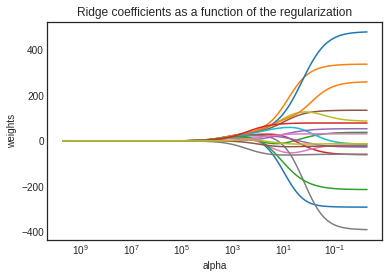

In [11]:
alphas = 10**np.linspace(10,-2,100)*0.5

ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization');

The above plot shows that the Ridge coefficients get larger when we decrease alpha.

#### Alpha = 4

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

In [13]:
ridge2 = Ridge(alpha=len(X_)*11498/2)
ridge2.fit(scaler.transform(X_train), y_train)
pred = ridge2.predict(scaler.transform(X_test))
mean_squared_error(y_test, pred)

193147.46143016344

In [14]:
pd.Series(ridge2.coef_.flatten(), index=X.columns)

AtBat          0.015146
Hits           0.016050
HmRun          0.013561
Runs           0.015681
RBI            0.016782
Walks          0.019662
Years          0.010390
CAtBat         0.016570
CHits          0.017627
CHmRun         0.015072
CRuns          0.018771
CRBI           0.016697
CWalks         0.016821
PutOuts        0.003228
Assists       -0.007600
Errors         0.013672
League_N       0.003519
Division_W     0.003339
NewLeague_N    0.003499
dtype: float64

#### Alpha = $10^{10}$ 
This big penalty shrinks the coefficients to a very large degree and makes the model more biased, resulting in a higher MSE.

In [15]:
ridge2.set_params(alpha=10**10)
ridge2.fit(scale(X_train), y_train)
pred = ridge2.predict(scale(X_test))
mean_squared_error(y_test, pred)

193253.09741651407

#### Compute the regularization path using RidgeCV

In [16]:
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv.fit(scale(X_train), y_train)

RidgeCV(alphas=array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2.48851178e+07,
       1.88246790e+07, 1.42401793e+0...
       3.28966612e-01, 2.48851178e-01, 1.88246790e-01, 1.42401793e-01,
       1.07721735e-01, 8.14875417e-02, 6.16423370e-02, 4.66301673e-02,
       3.52740116e-02, 2.66834962e-02, 2.01850863e-02, 1.52692775e-02,
       1.15506485e-02, 8.73764200e-03, 6.60970574e-03, 5.00000000e-03]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring='neg_mean_squared_error', store_cv_values=False)

In [17]:
ridgecv.alpha_

115.5064850041579

In [18]:
ridge2.set_params(alpha=ridgecv.alpha_)
ridge2.fit(scale(X_train), y_train)
mean_squared_error(y_test, ridge2.predict(scale(X_test)))

97384.9295917259

In [19]:
pd.Series(ridge2.coef_.flatten(), index=X.columns)

AtBat           7.576771
Hits           22.596030
HmRun          18.971990
Runs           20.193945
RBI            21.063875
Walks          55.713281
Years          -4.687149
CAtBat         20.496892
CHits          29.230247
CHmRun         14.293124
CRuns          35.881788
CRBI           20.212172
CWalks         24.419768
PutOuts        16.128910
Assists       -44.102264
Errors         54.624503
League_N        5.771464
Division_W     -0.293713
NewLeague_N    11.137518
dtype: float64

### python-glmnet (update 2016-08-29)
This relatively new module is a wrapper for the fortran library used in the R package `glmnet`. It gives mostly the exact same results as described in the book. However, the `predict()` method does not give you the regression *coefficients* for lambda values not in the lambda_path. It only returns the predicted values.
https://github.com/civisanalytics/python-glmnet

In [20]:
grid = 10**np.linspace(10,-2,100)

ridge3 = gln.ElasticNet(alpha=0, lambda_path=grid)
ridge3.fit(X, y)

ElasticNet(alpha=0, cut_point=1.0, fit_intercept=True,
           lambda_path=array([1.00000000e+10, 7.56463328e+09, 5.72236766e+09, 4.32876128e+09,
       3.27454916e+09, 2.47707636e+09, 1.87381742e+09, 1.41747416e+09,
       1.07226722e+09, 8.11130831e+08, 6.13590727e+08, 4.64158883e+08,
       3.51119173e+08, 2.65608778e+08, 2.00923300e+08, 1.51991108e+08,
       1.14975700e+08, 8.69749003e+07, 6.5793322...
       2.15443469e-01, 1.62975083e-01, 1.23284674e-01, 9.32603347e-02,
       7.05480231e-02, 5.33669923e-02, 4.03701726e-02, 3.05385551e-02,
       2.31012970e-02, 1.74752840e-02, 1.32194115e-02, 1.00000000e-02]),
           lower_limits=-inf, max_features=None, max_iter=100000,
           min_lambda_ratio=0.0001, n_jobs=1, n_lambda=100, n_splits=3,
           random_state=None, scoring=None, standardize=True, tol=1e-07,
           upper_limits=inf, verbose=False)

#### Lambda 11498

In [21]:
ridge3.lambda_path_[49]

11497.569953977356

In [22]:
print('Intercept: {:.3f}'.format(ridge3.intercept_path_[49]))

Intercept: 407.356


In [23]:
pd.Series(np.round(ridge3.coef_path_[:,49], decimals=3), index=X.columns)

AtBat          0.037
Hits           0.138
HmRun          0.525
Runs           0.231
RBI            0.240
Walks          0.290
Years          1.108
CAtBat         0.003
CHits          0.012
CHmRun         0.088
CRuns          0.023
CRBI           0.024
CWalks         0.025
PutOuts        0.016
Assists        0.003
Errors        -0.021
League_N       0.085
Division_W    -6.215
NewLeague_N    0.301
dtype: float64

In [24]:
np.sqrt(np.sum(ridge3.coef_path_[:,49]**2))

6.3606122865384505

#### Lambda 705

In [25]:
ridge3.lambda_path_[59]

705.4802310718645

In [26]:
print('Intercept: {:.3f}'.format(ridge3.intercept_path_[59]))

Intercept: 54.325


In [27]:
pd.Series(np.round(ridge3.coef_path_[:,59], decimals=3), index=X.columns)

AtBat           0.112
Hits            0.656
HmRun           1.180
Runs            0.938
RBI             0.847
Walks           1.320
Years           2.596
CAtBat          0.011
CHits           0.047
CHmRun          0.338
CRuns           0.094
CRBI            0.098
CWalks          0.072
PutOuts         0.119
Assists         0.016
Errors         -0.704
League_N       13.684
Division_W    -54.659
NewLeague_N     8.612
dtype: float64

In [28]:
np.sqrt(np.sum(ridge3.coef_path_[:,59]**2))

57.11003436702412

#### Fit model using just the training set.

In [29]:
ridge4 = gln.ElasticNet(alpha=0, lambda_path=grid, scoring='mean_squared_error', tol=1e-12)
ridge4.fit(X_train, y_train.values.ravel())

ElasticNet(alpha=0, cut_point=1.0, fit_intercept=True,
           lambda_path=array([1.00000000e+10, 7.56463328e+09, 5.72236766e+09, 4.32876128e+09,
       3.27454916e+09, 2.47707636e+09, 1.87381742e+09, 1.41747416e+09,
       1.07226722e+09, 8.11130831e+08, 6.13590727e+08, 4.64158883e+08,
       3.51119173e+08, 2.65608778e+08, 2.00923300e+08, 1.51991108e+08,
       1.14975700e+08, 8.69749003e+07, 6.5793322...
       2.15443469e-01, 1.62975083e-01, 1.23284674e-01, 9.32603347e-02,
       7.05480231e-02, 5.33669923e-02, 4.03701726e-02, 3.05385551e-02,
       2.31012970e-02, 1.74752840e-02, 1.32194115e-02, 1.00000000e-02]),
           lower_limits=-inf, max_features=None, max_iter=100000,
           min_lambda_ratio=0.0001, n_jobs=1, n_lambda=100, n_splits=3,
           random_state=None, scoring='mean_squared_error', standardize=True,
           tol=1e-12, upper_limits=inf, verbose=False)

In [30]:
# prediction using lambda = 4
pred = ridge4.predict(X_test, lamb=4)
mean_squared_error(y_test.values.ravel(), pred)

101036.832308929

#### Lambda chosen by cross validation

In [31]:
ridge5 = gln.ElasticNet(alpha=0, scoring='mean_squared_error')
ridge5.fit(X_train, y_train.values.ravel())

ElasticNet(alpha=0, cut_point=1.0, fit_intercept=True, lambda_path=None,
           lower_limits=-inf, max_features=None, max_iter=100000,
           min_lambda_ratio=0.0001, n_jobs=1, n_lambda=100, n_splits=3,
           random_state=None, scoring='mean_squared_error', standardize=True,
           tol=1e-07, upper_limits=inf, verbose=False)

In [32]:
# Lambda with best CV performance
ridge5.lambda_max_

307.2007848050221

In [33]:
# Lambda larger than lambda_max_, but with a CV score that is within 1 standard deviation away from lambda_max_ 
ridge5.lambda_best_

array([3450.86024521])

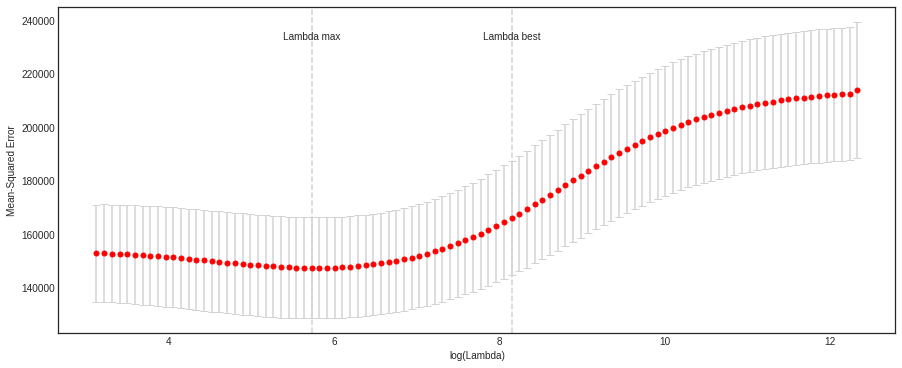

In [34]:
plt.figure(figsize=(15,6))
plt.errorbar(np.log(ridge5.lambda_path_), -ridge5.cv_mean_score_, color='r', linestyle='None', marker='o',
             markersize=5, yerr=ridge5.cv_standard_error_, ecolor='lightgrey', capsize=4)

for ref, txt in zip([ridge5.lambda_best_, ridge5.lambda_max_], ['Lambda best', 'Lambda max']):
    plt.axvline(x=np.log(ref), linestyle='dashed', color='lightgrey')
    plt.text(np.log(ref), .95*plt.gca().get_ylim()[1], txt, ha='center')

plt.xlabel('log(Lambda)')
plt.ylabel('Mean-Squared Error');

In [36]:
# MSE for lambda with best CV performance
pred = ridge5.predict(X_test, lamb=ridge5.lambda_max_)
mean_squared_error(y_test, pred)

96174.51562389842

#### Fit model to full data set

In [37]:
ridge6= gln.ElasticNet(alpha=0, scoring='mean_squared_error', n_splits=10)
ridge6.fit(X, y)

ElasticNet(alpha=0, cut_point=1.0, fit_intercept=True, lambda_path=None,
           lower_limits=-inf, max_features=None, max_iter=100000,
           min_lambda_ratio=0.0001, n_jobs=1, n_lambda=100, n_splits=10,
           random_state=None, scoring='mean_squared_error', standardize=True,
           tol=1e-07, upper_limits=inf, verbose=False)

In [38]:
# These are not really close to the ones in the book.
pd.Series(ridge6.coef_path_[:,ridge6.lambda_max_inx_], index=X.columns)

AtBat           -0.681594
Hits             2.772311
HmRun           -1.365704
Runs             1.014812
RBI              0.713030
Walks            3.378558
Years           -9.066826
CAtBat          -0.001200
CHits            0.136102
CHmRun           0.697992
CRuns            0.295890
CRBI             0.257072
CWalks          -0.278966
PutOuts          0.263887
Assists          0.169878
Errors          -3.685656
League_N        53.209503
Division_W    -122.834334
NewLeague_N    -18.102528
dtype: float64

### 6.6.2 The Lasso

### Scikit-learn



For both __glmnet__ in R and sklearn __Lasso()__ function the standard L1 penalty is:
### $$ \lambda |\beta|_1 $$

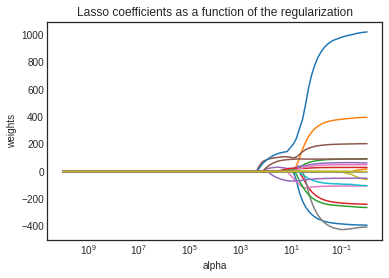

In [39]:
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas*2:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization');

In [40]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=10000)
lassocv.fit(scale(X_train), y_train.values.ravel())

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
        max_iter=10000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [41]:
lassocv.alpha_

30.01382256446427

In [42]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X_train), y_train)
mean_squared_error(y_test, lasso.predict(scale(X_test)))

102924.90954696965

In [43]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

AtBat            0.000000
Hits             0.000000
HmRun            2.154219
Runs             0.000000
RBI             30.835560
Walks          104.071528
Years           -0.000000
CAtBat           0.000000
CHits            0.000000
CHmRun           0.000000
CRuns          132.858095
CRBI             0.000000
CWalks           0.000000
PutOuts          1.896185
Assists        -51.058752
Errors          76.779641
League_N         0.000000
Division_W       0.000000
NewLeague_N      0.000000
dtype: float64

### python-glmnet

In [44]:
lasso2 = gln.ElasticNet(alpha=1, lambda_path=grid, scoring='mean_squared_error', n_splits=10)
lasso2.fit(X_train, y_train.values.ravel())

ElasticNet(alpha=1, cut_point=1.0, fit_intercept=True,
           lambda_path=array([1.00000000e+10, 7.56463328e+09, 5.72236766e+09, 4.32876128e+09,
       3.27454916e+09, 2.47707636e+09, 1.87381742e+09, 1.41747416e+09,
       1.07226722e+09, 8.11130831e+08, 6.13590727e+08, 4.64158883e+08,
       3.51119173e+08, 2.65608778e+08, 2.00923300e+08, 1.51991108e+08,
       1.14975700e+08, 8.69749003e+07, 6.5793322...
       2.15443469e-01, 1.62975083e-01, 1.23284674e-01, 9.32603347e-02,
       7.05480231e-02, 5.33669923e-02, 4.03701726e-02, 3.05385551e-02,
       2.31012970e-02, 1.74752840e-02, 1.32194115e-02, 1.00000000e-02]),
           lower_limits=-inf, max_features=None, max_iter=100000,
           min_lambda_ratio=0.0001, n_jobs=1, n_lambda=100, n_splits=10,
           random_state=None, scoring='mean_squared_error', standardize=True,
           tol=1e-07, upper_limits=inf, verbose=False)

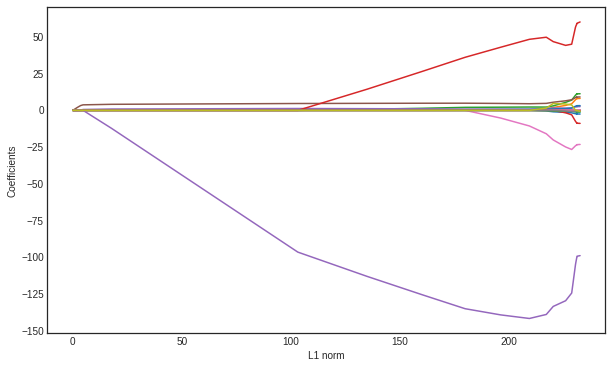

In [45]:
l1_norm = np.sum(np.abs(lasso2.coef_path_), axis=0)

plt.figure(figsize=(10,6))
plt.plot(l1_norm, lasso2.coef_path_.T)
plt.xlabel('L1 norm')
plt.ylabel('Coefficients');

#### Let glmnet() create a grid to use in CV

In [47]:
lasso3 = gln.ElasticNet(alpha=1, scoring='mean_squared_error', n_splits=10)
lasso3.fit(X_train, y_train.values.ravel())

ElasticNet(alpha=1, cut_point=1.0, fit_intercept=True, lambda_path=None,
           lower_limits=-inf, max_features=None, max_iter=100000,
           min_lambda_ratio=0.0001, n_jobs=1, n_lambda=100, n_splits=10,
           random_state=None, scoring='mean_squared_error', standardize=True,
           tol=1e-07, upper_limits=inf, verbose=False)

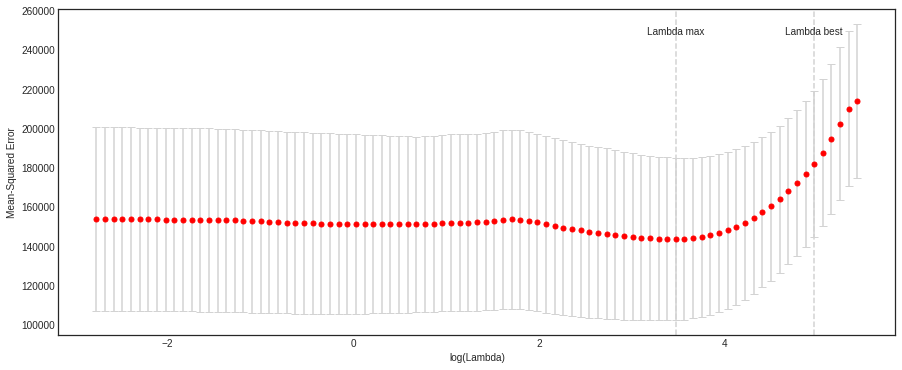

In [48]:
plt.figure(figsize=(15,6))
plt.errorbar(np.log(lasso3.lambda_path_), -lasso3.cv_mean_score_, color='r', linestyle='None', marker='o',
             markersize=5, yerr=lasso3.cv_standard_error_, ecolor='lightgrey', capsize=4)

for ref, txt in zip([lasso3.lambda_best_, lasso3.lambda_max_], ['Lambda best', 'Lambda max']):
    plt.axvline(x=np.log(ref), linestyle='dashed', color='lightgrey')
    plt.text(np.log(ref), .95*plt.gca().get_ylim()[1], txt, ha='center')

plt.xlabel('log(Lambda)')
plt.ylabel('Mean-Squared Error');

In [49]:
pred = lasso3.predict(X_test, lamb=lasso3.lambda_max_)
mean_squared_error(y_test, pred)

101910.38361204902

#### Fit model on full dataset

In [50]:
lasso4 = gln.ElasticNet(alpha=1, lambda_path=grid, scoring='mean_squared_error', n_splits=10)
lasso4.fit(X, y)

ElasticNet(alpha=1, cut_point=1.0, fit_intercept=True,
           lambda_path=array([1.00000000e+10, 7.56463328e+09, 5.72236766e+09, 4.32876128e+09,
       3.27454916e+09, 2.47707636e+09, 1.87381742e+09, 1.41747416e+09,
       1.07226722e+09, 8.11130831e+08, 6.13590727e+08, 4.64158883e+08,
       3.51119173e+08, 2.65608778e+08, 2.00923300e+08, 1.51991108e+08,
       1.14975700e+08, 8.69749003e+07, 6.5793322...
       2.15443469e-01, 1.62975083e-01, 1.23284674e-01, 9.32603347e-02,
       7.05480231e-02, 5.33669923e-02, 4.03701726e-02, 3.05385551e-02,
       2.31012970e-02, 1.74752840e-02, 1.32194115e-02, 1.00000000e-02]),
           lower_limits=-inf, max_features=None, max_iter=100000,
           min_lambda_ratio=0.0001, n_jobs=1, n_lambda=100, n_splits=10,
           random_state=None, scoring='mean_squared_error', standardize=True,
           tol=1e-07, upper_limits=inf, verbose=False)

In [51]:
# These are not really close to the ones in the book.
pd.Series(lasso4.coef_path_[:,lasso4.lambda_max_inx_], index=X.columns)

AtBat           -1.560098
Hits             5.693168
HmRun            0.000000
Runs             0.000000
RBI              0.000000
Walks            4.750540
Years           -9.518024
CAtBat           0.000000
CHits            0.000000
CHmRun           0.519161
CRuns            0.660407
CRBI             0.391541
CWalks          -0.532687
PutOuts          0.272620
Assists          0.174816
Errors          -2.056721
League_N        32.109569
Division_W    -119.258342
NewLeague_N      0.000000
dtype: float64

# Lab 3

### 6.7.1 Principal Components Regression

Scikit-klearn does not have an implementation of PCA and regression combined like the 'pls' package in R.
https://cran.r-project.org/web/packages/pls/vignettes/pls-manual.pdf

In [52]:
pca = PCA()
X_reduced = pca.fit_transform(scale(X))

print(pca.components_.shape)
pd.DataFrame(pca.components_.T).loc[:4,:5]

(19, 19)


,0,1,2,3,4,5
0,0.198290,-0.383784,0.088626,0.031967,0.028117,-0.070646
1,0.195861,-0.377271,0.074032,0.017982,-0.004652,-0.082240
2,0.204369,-0.237136,-0.216186,-0.235831,0.077660,-0.149646
3,0.198337,-0.377721,-0.017166,-0.049942,-0.038536,-0.136660
4,0.235174,-0.314531,-0.073085,-0.138985,0.024299,-0.111675


The above loadings are the same as in R.

In [53]:
print(X_reduced.shape)
pd.DataFrame(X_reduced).loc[:4,:5]

(263, 19)


,0,1,2,3,4,5
0,-0.009649,1.870522,1.265145,-0.935481,1.109636,1.211972
1,0.411434,-2.429422,-0.909193,-0.264212,1.232031,1.826617
2,3.466822,0.825947,0.555469,-1.616726,-0.857488,-1.028712
3,-2.558317,-0.230984,0.519642,-2.176251,-0.820301,1.491696
4,1.027702,-1.573537,1.331382,3.494004,0.983427,0.513675


The above principal components are the same as in R.

In [54]:
# Variance explained by the principal components
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([38.31, 60.15, 70.84, 79.03, 84.29, 88.63, 92.26, 94.96, 96.28,
       97.25, 97.97, 98.64, 99.14, 99.46, 99.73, 99.88, 99.95, 99.98,
       99.99])

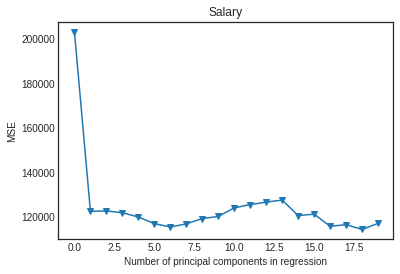

In [55]:
# 10-fold CV, with shuffle
n = len(X_reduced)
kf_10 = KFold(n_splits=10, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_val_score(regr, X_reduced[:,:i], y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

The above plot indicates that the lowest training MSE is reached when doing regression on 18 components.

In [56]:
regr_test = LinearRegression()
regr_test.fit(X_reduced, y)
regr_test.coef_

array([ 106.36859204,  -21.60350456,   24.2942534 ,  -36.9858579 ,
        -58.41402748,   62.20632652,   24.63862038,   15.82817701,
         29.57680773,   99.64801199,  -30.11209105,   20.99269291,
         72.40210574, -276.68551696,  -74.17098665,  422.72580227,
       -347.05662353, -561.59691587,  -83.25441536])

#### Fitting PCA with training data

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


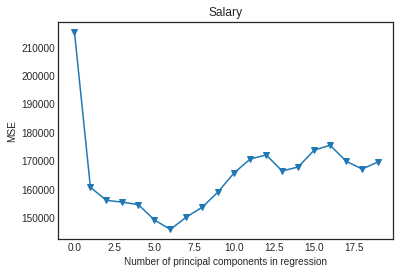

In [57]:
pca2 = PCA()
X_reduced_train = pca2.fit_transform(scale(X_train))
n = len(X_reduced_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=False, random_state=1)

mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_val_score(regr, X_reduced_train[:,:i], y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

The above plot indicates that the lowest training MSE is reached when doing regression on 6 components.

#### Transform test data with PCA loadings and fit regression on 6 principal components

In [58]:
X_reduced_test = pca2.transform(scale(X_test))[:,:7]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:7], y_train)

# Prediction with test data
pred = regr.predict(X_reduced_test)
mean_squared_error(y_test, pred)

96320.02078250323

### 6.7.2 Partial Least Squares

Scikit-learn PLSRegression gives same results as the pls package in R when using 'method='oscorespls'. In the LAB excercise, the standard method is used which is 'kernelpls'. 

When doing a slightly different fitting in R, the result is close to the one obtained using scikit-learn.

    pls.fit=plsr(Salary~., data=Hitters, subset=train, scale=TRUE, validation="CV", method='oscorespls')
    validationplot(pls.fit,val.type="MSEP", intercept = FALSE)
   
See documentation:
http://scikit-learn.org/dev/modules/generated/sklearn.cross_decomposition.PLSRegression.html#sklearn.cross_decomposition.PLSRegression

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


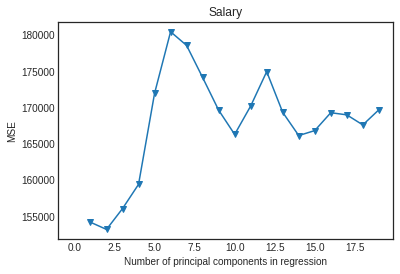

In [59]:
n = len(X_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=False, random_state=1)

mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = cross_val_score(pls, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

plt.plot(np.arange(1, 20), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

In [60]:
pls = PLSRegression(n_components=2)
pls.fit(scale(X_train), y_train)

mean_squared_error(y_test, pls.predict(scale(X_test)))

102234.27995999217